In [17]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats

from bokeh.models import Label
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [18]:
def obtain_topic_keys(topic_matrix):
    topic_keys = topic_matrix.argmax(axis=1).tolist()
    return topic_keys

def count_topic_keys(topic_keys):
    key_count_pairs = Counter(topic_keys).items()
    categories = [pair[0] for pair in key_count_pairs]
    counts = [pair[1] for pair in key_count_pairs]
    return (categories, counts)

def find_top_n_words(n, topic_keys, doc_term_matrix, count_vectorizer, num_topics):
    top_indices_per_topic = []
    for topic in range(num_topics):
        topic_vector_sum = 0
        for idx, key in enumerate(topic_keys):
            if key == topic:
                topic_vector_sum += doc_term_matrix[idx]
        topic_vector_sum = topic_vector_sum.toarray()
        top_n_indices = np.flip(np.argsort(topic_vector_sum)[0][-n:], 0)
        top_indices_per_topic.append(top_n_indices)
    
    top_words_per_topic = []
    for topic_indices in top_indices_per_topic:
        words_in_topic = []
        for index in topic_indices:
            word_vector = np.zeros((1, doc_term_matrix.shape[1]))
            word_vector[:, index] = 1
            word = count_vectorizer.inverse_transform(word_vector)[0][0]
            words_in_topic.append(word.encode('ascii').decode('utf-8'))
        top_words_per_topic.append(" ".join(words_in_topic))
    return top_words_per_topic

def compute_mean_topic_vectors(topic_keys, two_d_vectors, num_topics):
    avg_topic_vectors = []
    for t in range(num_topics):
        topic_vectors = []
        for idx, key in enumerate(topic_keys):
            if key == t:
                topic_vectors.append(two_d_vectors[idx])
        
        topic_vectors = np.vstack(topic_vectors)
        mean_vector = np.mean(topic_vectors, axis=0)
        avg_topic_vectors.append(mean_vector)
    return avg_topic_vectors

In [19]:
def analyze_topics(data, sample_size):
    headlines = data['headline_text']
    headlines.index = data['publish_date']
    
    count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
    text_sample = headlines.sample(n=sample_size, random_state=0).values
    
    print('Headline before vectorization: {}'.format(text_sample[99]))
    document_term_matrix = count_vectorizer.fit_transform(text_sample)
    print('Headline after vectorization: \n{}'.format(document_term_matrix[99]))
    
    num_topics = 10
    lsa = TruncatedSVD(n_components=num_topics)
    lsa_topic_matrix = lsa.fit_transform(document_term_matrix)
    
    lsa_keys = obtain_topic_keys(lsa_topic_matrix)
    lsa_categories, lsa_counts = count_topic_keys(lsa_keys)
    
    top_words_lsa = find_top_n_words(10, lsa_keys, document_term_matrix, count_vectorizer, num_topics)
    for i, words in enumerate(top_words_lsa):
        print("Topic {}: ".format(i + 1), words)
        
    top_3_words = find_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer, num_topics)
    labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]
    
    plot_topic_counts(lsa_categories, lsa_counts, labels, 'LSA')
    
    tsne_lsa_vectors = fit_tsne(lsa_topic_matrix)
    plot_tsne_clusters(num_topics, tsne_lsa_vectors, lsa_keys, 'LSA')
    
    lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0, verbose=0)
    lda_topic_matrix = lda.fit_transform(document_term_matrix)
    
    lda_keys = obtain_topic_keys(lda_topic_matrix)
    lda_categories, lda_counts = count_topic_keys(lda_keys)
    
    top_words_lda = find_top_n_words(10, lda_keys, document_term_matrix, count_vectorizer, num_topics)
    for i, words in enumerate(top_words_lda):
        print("Topic {}: ".format(i + 1), words)
        
    top_3_words = find_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer, num_topics)
    labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]
    
    plot_topic_counts(lda_categories, lda_counts, labels, 'LDA')
    
    tsne_lda_vectors = fit_tsne(lda_topic_matrix)
    plot_tsne_clusters(num_topics, tsne_lda_vectors, lda_keys, 'LDA')

def plot_topic_counts(categories, counts, labels, method_name):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.bar(categories, counts)
    ax.set_xticks(categories)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Number of headlines')
    ax.set_title('{} topic counts'.format(method_name))
    plt.show()

def fit_tsne(topic_matrix):
    tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
    return tsne_model.fit_transform(topic_matrix)

def plot_tsne_clusters(num_topics, tsne_vectors, keys, method_name):
    colormap = np.array([
        "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
        "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
        "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
        "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"])
    colormap = colormap[:num_topics]
    
    top_3_words = find_top_n_words(3, keys, document_term_matrix, small_count_vectorizer, num_topics)
    mean_topic_vectors = compute_mean_topic_vectors(keys, tsne_vectors, num_topics)
    
    plot = figure(title="t-SNE Clustering of {} {} Topics".format(num_topics, method_name), plot_width=700, plot_height=700)
    plot.scatter(x=tsne_vectors[:, 0], y=tsne_vectors[:, 1], color=colormap[keys])
    
    for t in range(num_topics):
        label = Label(x=mean_topic_vectors[t][0], y=mean_topic_vectors[t][1],text=top_3_words[t], text_color=colormap[t])
        plot.add_layout(label)
    show(plot)

In [20]:
def LDA(data):
    n_topics=8
    reindexed_data = data['headline_text']
    reindexed_data.index = data['publish_date']
    big_sample_size = 100000 

    big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
    big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
    big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

    big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
    big_lda_model.fit(big_document_term_matrix);
    yearly_data = []
    for i in range(2003,2017+1):
        yearly_data.append(reindexed_data['{}'.format(i)].values)
    yearly_topic_matrices = []
    for year in yearly_data:
        document_term_matrix = big_count_vectorizer.transform(year)
        topic_matrix = big_lda_model.transform(document_term_matrix)
        yearly_topic_matrices.append(topic_matrix)

    yearly_keys = []
    print(topic_matrix)
    for topic_matrix in yearly_topic_matrices:
        yearly_keys.append(obtain_topic_keys(topic_matrix))

    yearly_counts = []
    for keys in yearly_keys:
        categories, counts = count_topic_keys(keys)
        yearly_counts.append(counts)

    yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2017+1))
    yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

    print(yearly_topic_counts)
    fig, ax = plt.subplots(figsize=(14,10))
    sb.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
    plt.show()

In [21]:
def LSA(data):
    n_topics=8
    reindexed_data = data['headline_text']
    reindexed_data.index = data['publish_date']
    big_sample_size = 100000 

    big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
    big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
    big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

    big_lda_model = TruncatedSVD(n_components=n_topics)
    big_lda_model.fit(big_document_term_matrix);
    yearly_data = []
    for i in range(2003,2017+1):
        yearly_data.append(reindexed_data['{}'.format(i)].values)
    yearly_topic_matrices = []
    for year in yearly_data:
        document_term_matrix = big_count_vectorizer.transform(year)
        topic_matrix = big_lda_model.transform(document_term_matrix)
        yearly_topic_matrices.append(topic_matrix)

    yearly_keys = []
    print(topic_matrix)
    for topic_matrix in yearly_topic_matrices:
        yearly_keys.append(obtain_topic_keys(topic_matrix))

    yearly_counts = []
    for keys in yearly_keys:
        categories, counts = count_topic_keys(keys)
        yearly_counts.append(counts)

    yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2017+1))
    yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

    print(yearly_topic_counts)
    fig, ax = plt.subplots(figsize=(14,10))
    sb.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
    plt.show()

Headline before vectorization: french polynesian doctor satisfied with zika virus
Headline after vectorization: 
  (0, 36119)	1
  (0, 13710)	1
  (0, 26028)	1
  (0, 10581)	1
  (0, 29681)	1
  (0, 37823)	1
Topic 1:  police death car missing search attack probe dead house melbourne
Topic 2:  new year laws zealand life opens named years gets president
Topic 3:  man charged murder dies guilty jailed child arrested pleads court
Topic 4:  says report minister pm mp labor trump iraq election time
Topic 5:  govt australian plan qld health wa water government calls urged
Topic 6:  court face accused case charges told high faces murder alleged
Topic 7:  australia day world cup win south coronavirus china test final
Topic 8:  council plan city mayor considers land rejects seeks water backs
Topic 9:  nsw coast rural sydney news gold abc country farmers hour
Topic 10:  interview crash killed plane speaks nrl michael john extended afl


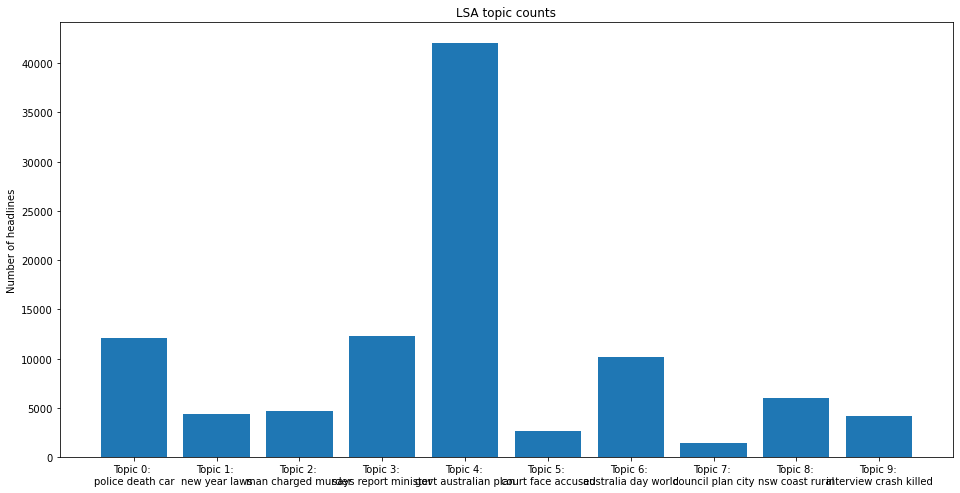

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.109s...
[t-SNE] Computed neighbors for 100000 samples in 45.010s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

In [22]:
data = pd.read_csv('dataset/abcnews-date-text.csv', parse_dates=[0], infer_datetime_format=True)
analyze_topics(data, 100000)

In [ ]:
LDA(data)

In [ ]:
LSA(data)